# Checking for bad maps

In [211]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
import sys
sys.path.append("..")
import os
from utils.model3 import Net_mask
from utils.data import Data
from utils.loss_experiment import Loss
from scripts.parameters import get_parameters
import torch
import numpy as np
import matplotlib.pyplot as plt

In [213]:
tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps, tensor_Q_m, sigma2_eps, tau2 = get_parameters()
data_generator = Data(tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps)

In [214]:
tensor_raw = data_generator.get_tensor_data(1, [1, 2.5, 1, 2.5, 1], [0, 4,5,6, 9])

In [215]:
#tensor_raw = data_generator.get_tensor_data(1, [2, 2, -2, -2.5, -2], [1, 3, 4, 5, 8])
#tensor_raw = data_generator.get_tensor_data(1, [0, 2.5, -1, -0.5], [3, 5, 6, 7]) # nr 1, bad=1, points=4
#tensor_raw = data_generator.get_tensor_data(1, [1, 1, -0.3, -0.8], [0, 1, 3, 5]) # nr 2, bad=6, points=4
#tensor_raw = data_generator.get_tensor_data(1, [-0.6, 1.4, 0.5, 1.2], [1, 3, 6, 9]) # nr 3, bad=0, points=4
#tensor_raw = data_generator.get_tensor_data(1, [0.4, -0.7, -2, 0], [1, 2, 5, 8]) # nr 4, bad=3, points=4
#tensor_raw = data_generator.get_tensor_data(1, num=4)
#tensor_raw = data_generator.get_tensor_data(1)

In [216]:
tensor_raw = torch.tensor([[-1.5355, -0.5029, -0.0000, -0.0000,  2.2948, -0.0000, -1.2828, -0.0000,
         -0.2302, -0.5603,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  1.0000]])

In [217]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
tau2 = 1000 # 1/tau2 is the noise added to the diagonal
tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
loss = Loss(tensor_Q_m_modified, sigma2_eps, 1/(0.5**2*100_000))

losses = torch.zeros(100)
for f in range(100): 
    name = '../saved_models/combined2/map/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    losses[f] = loss.loss(tensor_raw, out_raw, model)[0] 
#print(losses)
#print(torch.argmax(losses))
largest_loss = torch.argmax(losses)
print(largest_loss)

tensor(13)


tensor([[-1.5355, -0.5029, -0.0000, -0.0000,  2.2948, -0.0000, -1.2828, -0.0000,
         -0.2302, -0.5603,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  1.0000]])


(-0.5, 9.5, -3.0, 3.0)

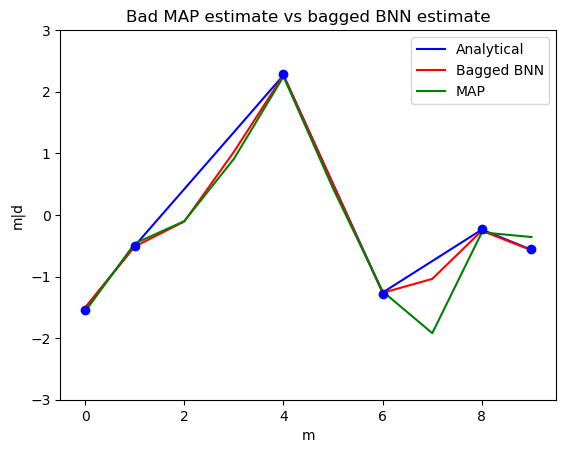

In [218]:
# bad maps and avg bnn
# Getting tensor
print(tensor_raw)
n_param = 10
input_tensor = tensor_raw[0]
mask = input_tensor[10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
points = tensor_raw[0][location_raw]
post_mean, _ = data_generator.get_tensor_posterior(input_tensor)

# Plotting model estimates
model = Net_mask()

names = []
sum_tensor_map = torch.zeros(n_param)

plt.plot(range(10), post_mean, 'b')
sum_tensor_bnn = torch.zeros(n_param)
for f in range(100): 
    name = '../saved_models/combined2/pos/' + str(f) + '/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    sum_tensor_bnn += out
    #plt.plot(range(10), out, alpha=0.5)#, 'o')
plt.plot(range(10), sum_tensor_bnn/100, 'r')

#for f in range(100): 
for f in [largest_loss]: 
    name = f'../saved_models/combined2/map/{largest_loss}/' + 'model_weights.pth'
    #name = f'../saved_models/combined2/map/{f}/' + 'model_weights.pth'
    model.load_state_dict(torch.load(name))
    model.eval()
    out_raw = model(tensor_raw)
    out = out_raw[0].detach()
    sum_tensor_map += out
    #plt.plot(range(10), out, alpha=0.5)#, 'o')
    plt.plot(range(10), out, 'g')#, 'o')
    names.append(str(f))


plt.plot(location, points, 'bo')
plt.title("Bad MAP estimate vs bagged BNN estimate")
plt.xlabel("m")
plt.ylabel("m|d")
plt.legend(['Analytical', 'Bagged BNN', 'MAP'])
#plt.legend(names)
plt.axis([-0.5, 9.5, -3, 3])
#plt.savefig('../figures/bad_map_vs_bnn3.pdf')
